In [229]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from collections import deque

In [241]:
# sample data used for simulation is AI generated. real world data can be compiled via yfinance
# sample data is sorted by bid-ask spread (lowest to highest)
lbook = pd.read_csv('limitbook_sample_data.csv')
lbook

,type,b_price,b_amount,type.1,s_price,s_amount
0,b,21999.44,0.447,s,22000.87,0.725
1,b,21998.64,1.144,s,22001.41,3.165
2,b,21998.05,1.579,s,22002.03,3.313
3,b,21997.75,0.882,s,22002.52,2.175
4,b,21997.41,3.039,s,22003.14,0.306
...,...,...,...,...,...,...
495,b,21760.66,4.872,s,22242.65,2.243
496,b,21760.12,1.565,s,22242.92,0.929
497,b,21759.56,3.347,s,22243.37,4.145
498,b,21759.19,1.637,s,22243.61,0.165


In [231]:
class LimitOrderBook:
    def __init__(self, lbook):
        self.sell = lbook[['s_price', 's_amount']].rename(columns={"s_price": "price", "s_amount": "amount"})
        self.buy = lbook[['b_price', 'b_amount']].rename(columns={"b_price": "price", "b_amount": "amount"})
        self.trades = pd.DataFrame(columns=["price", "amount"])

    def limit_order(self, side, price, amount):
        if side == 'buy':
            self.buy.loc[len(self.buy)] = [price, amount]
            self.buy = self.buy.sort_values(by='price', ascending=False).reset_index(drop=True)
        else:
            self.sell.loc[len(self.sell)] = [price, amount]
            self.sell = self.sell.sort_values(by='price').reset_index(drop=True)

        self.match_orders()

    def market_order(self, side, amount):
        if (side == 'buy'):
            book = self.sell
        else:
            book = self.buy
            
        i = 0
        lentrades = len(self.trades)
        while (amount > 0) and (i < len(book)):
            match_amount = min(amount, book.loc[i, 'amount'])

            self.trades.loc[lentrades + i] = [book.loc[i, 'price'], match_amount]
            
            book.loc[i, 'amount'] -= match_amount
            amount -= match_amount
            
            if book.loc[i, 'amount'] == 0:
                book = book.drop(index=i)
           
            i += 1
            
        book = book.reset_index(drop=True)
        
        if (side == 'buy'):
            self.sell = book
        else:
            self.buy = book

    def match_orders(self):
        i = 0
        while not self.buy.empty and not self.sell.empty:
            best_buy = self.buy.iloc[0]
            best_sell = self.sell.iloc[0]
            
            if best_buy['price'] >= best_sell['price']:
                trade_amount = min(best_buy['amount'], best_sell['amount'])
                trade_price = best_sell['price']

                self.trades.loc[len(self.trades) + i] = [trade_price, trade_amount]
                
                self.buy.loc[0, 'amount'] -= trade_amount
                self.sell.loc[0, 'amount'] -= trade_amount

                if self.buy.loc[0, 'amount'] == 0:
                    self.buy = self.buy.iloc[1:].reset_index(drop=True)
                if self.sell.loc[0, 'amount'] == 0:
                    self.sell = self.sell.iloc[1:].reset_index(drop=True)
                
            else:
                break

            i += 1

    def plot_order_book(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.buy['price'], label='Buy Orders', color='r')
        plt.plot(self.sell['price'], label='Sell Orders', color='b')
        plt.title('Limit Order Book')
        plt.xlabel('Order Index')
        plt.ylabel('Price')
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_trade_history(self):
        if not self.trades.empty:
            plt.figure(figsize=(10, 5))
            plt.plot(self.trades['price']/self.trades['amount'], label='Trade Price per Share', marker='o')
            plt.title('Trade Execution History')
            plt.xlabel('Trade Index')
            plt.ylabel('Price')
            plt.legend()
            plt.grid(True)
            plt.show()
        else:
            print("No trades executed yet.")
    

In [232]:
# demonstrating market order functionality
lob = LimitOrderBook(lbook)
lob.market_order('buy', 3)
display(lob.trades)
print("Total shares traded:", sum(lob.trades['amount']))

,price,amount
0,22000.87,0.725
1,22001.41,2.275


Total shares traded: 3.0


In [233]:
# demonstrating limit order functionality
lob = LimitOrderBook(lbook)
lob.limit_order('buy', 22002, 3)
display(lob.trades)
print("Total shares traded:", sum(lob.trades['amount']))

,price,amount
0,22000.87,0.725
2,22001.41,2.275


Total shares traded: 3.0


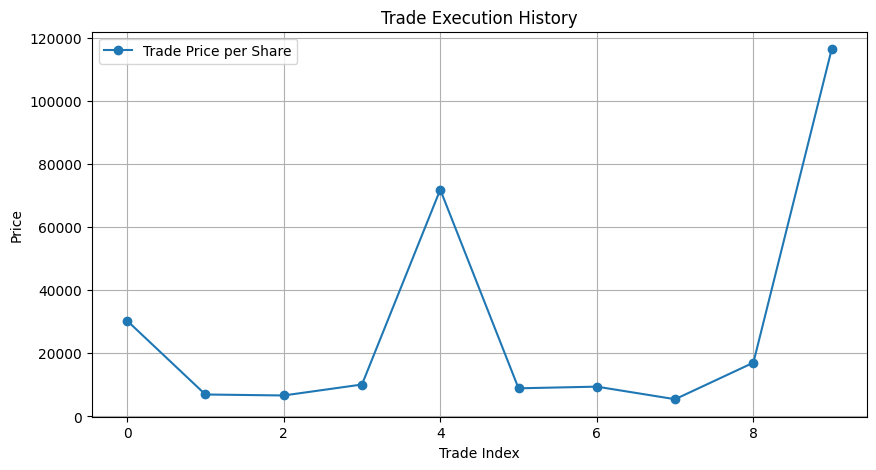

In [234]:
# demonstrating graphs
lob = LimitOrderBook(lbook)
lob.market_order('buy', 20)
lob.plot_trade_history()